# ETL
    1. Get tickers from finviz
    2. Get historic data using yfinance
    3. Compute daily returns based on Adjusted close price

In [2]:
from finvizfinance.screener.overview import Overview
import yfinance as yf
import riskfolio as rp

In [3]:
overView = Overview()
overView.set_filter(signal="New High", filters_dict= {'Price': 'Over $15', 'Country':'USA', 'Market Cap.':'+Mid (over $2bln)'})
new_high_data = overView.screener_view()

d:\anaconda3\envs\quant-stack-bk\lib\site-packages\finvizfinance\screener\overview.py:203: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df, pd.DataFrame(frame)], ignore_index=True)


In [4]:
tickers = new_high_data.Ticker.to_list()
tickers.sort()

In [5]:
historic_ticker_data = yf.download(tickers=tickers, start = '2020-01-01', end = '2023-10-31')
historic_ticker_data = historic_ticker_data.loc[:,('Adj Close', slice(None))]
historic_ticker_data.columns = tickers

[*********************100%%**********************]  29 of 29 completed


In [6]:
daily_returns = historic_ticker_data[tickers].pct_change().dropna()

## Risk Analysis

In [7]:
portfolio = rp.Portfolio(returns=daily_returns)

In [8]:
# Define params for risk parity optimizer
portfolio.lowerret = 0.0008
portfolio.assets_stats(method_mu="hist", method_cov="hist", d=0.94)
w_rp = portfolio.rp_optimization(model="Classic", rm="MV", rf=0.05, hist=True)

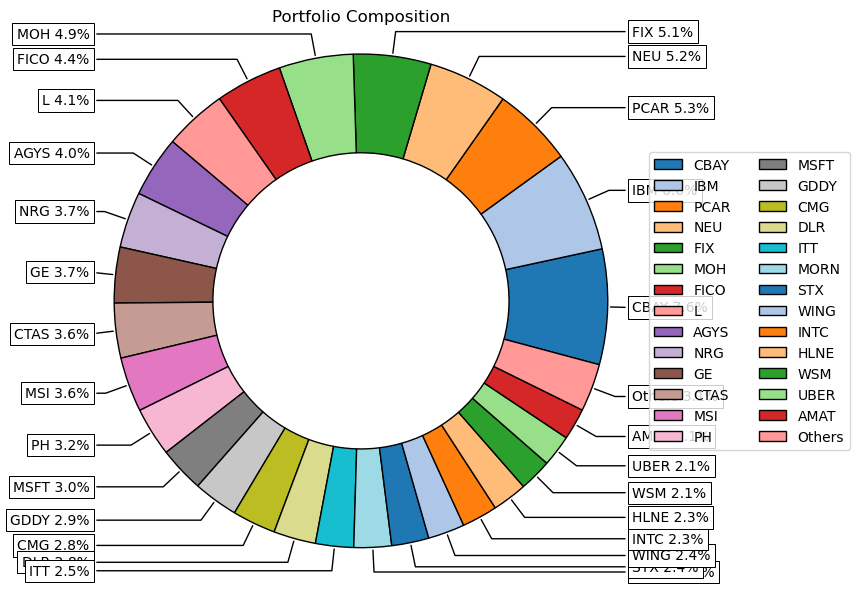

In [9]:
pie = rp.plot_pie(
    w=w_rp
)

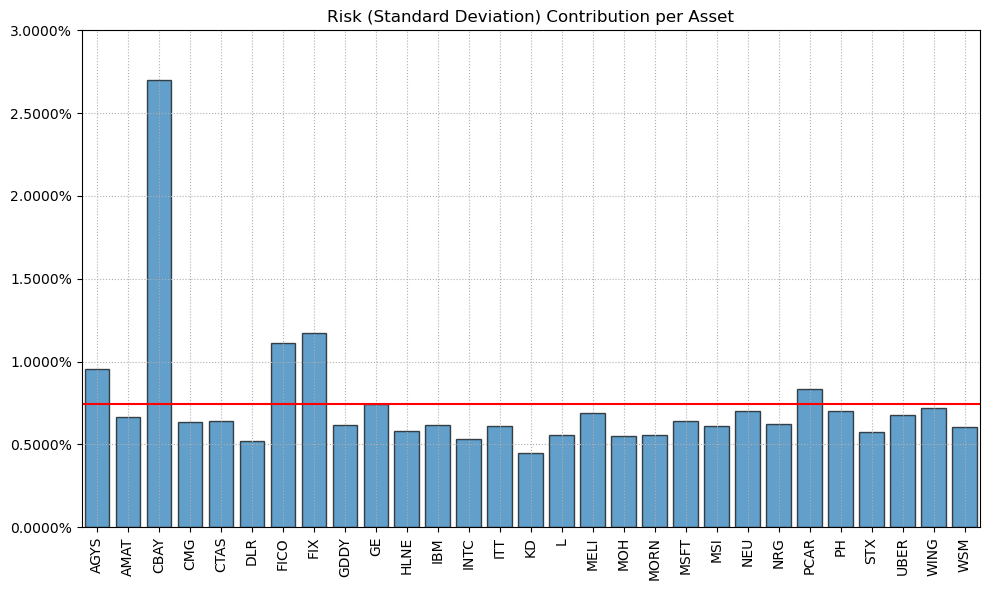

In [10]:
ax = rp.plot_risk_con(
    w=w_rp,
    cov= portfolio.cov,
    returns= portfolio.returns,
    rm="MV",
    rf=0.05
)

In [11]:
portfolio_value = 100_000

In [12]:
w_rp['investment_amount'] = w_rp * portfolio_value # weight * Market Value

In [13]:
w_rp['last_price'] = historic_ticker_data.iloc[-1]

In [14]:
w_rp['shares'] = round(w_rp.investment_amount / w_rp.last_price)

w_rp

,weights,investment_amount,last_price,shares
AGYS,0.039997,3999.731278,82.610001,48.0
AMAT,0.020645,2064.473696,131.029999,16.0
CBAY,0.075504,7550.430134,16.400000,460.0
CMG,0.028423,2842.292856,1909.300049,1.0
CTAS,0.035878,3587.757135,501.544220,7.0
DLR,0.027643,2764.250059,122.080002,23.0
FICO,0.043609,4360.919852,851.289978,5.0
FIX,0.050811,5081.132148,179.267441,28.0
GDDY,0.029324,2932.423177,72.379997,41.0
GE,0.036512,3651.229744,109.809998,33.0


In [15]:
(w_rp['shares'] * w_rp['last_price']).sum()

98663.82847976685

# IBroker automation

In [16]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
from ibapi.order import *

import time
import threading

In [17]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
    
    def nextValidId(self, orderId: int):
        super().nextValidId(orderId)
        self.nextOrderId = orderId
    

In [18]:
def stock_contract(symbol, secType="STK", exchange="SMART", currency="USD"):
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    return contract


def submit_order(contract, direction, qty=100, orderType="MKT", transmit=True):
    order = Order()
    order.action = direction
    order.totalQuantity = qty
    order.orderType = orderType
    order.transmit = transmit
    order.eTradeOnly = ""
    order.firmQuoteOnly = ""
    # submit order
    app.placeOrder(app.nextOrderId, contract, order)
    app.nextOrderId += 1

In [19]:
def run_loop():
    app.run()

app = IBapi()
app.connect('127.0.0.1', 7497, 123)
app.nextOrderId = None

api_thread = threading.Thread(target=run_loop, daemon=True)
api_thread.start()

while True:
    if isinstance(app.nextOrderId, int):
        print("Connected")
        break
    else:
        print("Waiting")
        time.sleep(1)

ERROR -1 502 Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002


Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting


KeyboardInterrupt: 

In [ ]:
for row in w_rp.itertuples():
    contract = stock_contract(row.Index)
    submit_order(contract, direction="BUY", qty=row.shares)

ERROR 70 200 The contract description specified for IBM is ambiguous.
ERROR 86 200 The contract description specified for WING is ambiguous.
ERROR 60 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 77 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 78 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 71 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 81 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 85 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 59 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 64 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 62 202 Order Canceled - reason:No market data on major exchange for market order.
ERROR 63 202 Order Canceled - reason:No market data on major exchan